# Covid-19 cases in Finland


Quick exploration of the COVID-19 cases in Finland based on a [data set shared by the Helsingin Sanomat datadesk](https://github.com/HS-Datadesk/koronavirus-avoindata) which I spotted on [Twitter](https://twitter.com/EsaMakinen/status/1237007961853173761).

Importing required python packages:

In [1]:
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

## Read and preprocess input data


- **Coronavirus cases in Finland**
    - Data compiled by Helsingin Sanomat Datadesk
    - Json file downloaded from https://github.com/HS-Datadesk/koronavirus-avoindata




In [2]:
# Reading the json as a dict
# with a little help from here: https://stackoverflow.com/questions/28373282/how-to-read-a-json-dictionary-type-file-with-pandas
with open('latestData.json') as json_data:
    data_dict = json.load(json_data)

There is a placeholder also for deaths (no data on deaths at the time of writing this)..

In [3]:
data_dict.keys()

dict_keys(['confirmed', 'deaths'])

We will continue with the confirmed cases:

In [4]:
covid = pd.DataFrame.from_dict(data_dict["confirmed"])
covid.head()

,id,date,healthCareDistrict,infectionSourceCountry,infectionSource
0,1,2020-01-29T13:00:00.000Z,Lappi,CHN,unknown
1,2,2020-02-26T13:00:00.000Z,HUS,ITA,unknown
2,3,2020-03-01T13:00:00.000Z,HUS,FIN,2
3,4,2020-02-28T13:00:00.000Z,HUS,ITA,unknown
4,5,2020-03-01T13:00:00.000Z,HUS,FIN,4


In [5]:
print("number of confirmed cases in this input data:", len(covid))

number of confirmed cases in this input data: 30


- **Health districts**
    - Downloaded Excel with list of **Finnish municipalities with health district information** https://www.kuntaliitto.fi/sosiaali-ja-terveysasiat/sairaanhoitopiirien-jasenkunnat
    - File `Shp_jäsenkunnat_2020.xls`, sheet `kunnat_shp_2020_ aakkosjärj.`
    - "shp" stands for "sairaanhoitopiiri" (health district in Finnish)

In [6]:
data = pd.read_excel("Shp_jäsenkunnat_2020.xls", sheet_name="kunnat_shp_2020_ aakkosjärj.", header=3)

In [7]:
data.head()

,kunta-\nkoodi,kunta,shp:n koodi,sairaanhoitopiiri,erva-alue,kuntien lkm
0,NaN,NaN,NaN,NaN,NaN,NaN
1,20.0,Akaa,6.0,Pirkanmaa,TAYS,1.0
2,5.0,Alajärvi,15.0,Etelä-Pohjanmaa,TAYS,2.0
3,9.0,Alavieska,18.0,Pohjois-Pohjanmaa,OYS,3.0
4,10.0,Alavus,15.0,Etelä-Pohjanmaa,TAYS,4.0


The data needs some fixing and cleaning after reading the excel sheet

In [8]:
data = data.dropna()
data.rename(columns={"kunta-\nkoodi":"code", 'sairaanhoitopiiri':'healthCareDistrict'}, inplace=True)
data = data[['code','healthCareDistrict']]

In [9]:
# Truncate and convert to character string
data["code"] = data["code"].astype(int).astype('str')

# Add missing zeros to municipality codes
data["code"] = data["code"].apply(lambda x: "00" + x if len(x)==1 else x)
data["code"] = data["code"].apply(lambda x: "0" + x if len(x)==2 else x)

In [10]:
data.head()

,code,healthCareDistrict
1,020,Pirkanmaa
2,005,Etelä-Pohjanmaa
3,009,Pohjois-Pohjanmaa
4,010,Etelä-Pohjanmaa
5,016,Päijät-Häme


- **Municipality polygons** via Statistics Finland web feature service: https://www.stat.fi/org/avoindata/paikkatietoaineistot/kuntapohjaiset_tilastointialueet.html

In [11]:
# For more info, see http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetCapabilities
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON"
geodata = gpd.read_file(url)

In [12]:
geodata.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k.1,005,2020,Alajärvi,Alajärvi,Alajärvi,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,2020,Alavieska,Alavieska,Alavieska,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,2020,Alavus,Alavus,Alavus,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,2020,Asikkala,Asikkala,Asikkala,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,2020,Askola,Askola,Askola,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


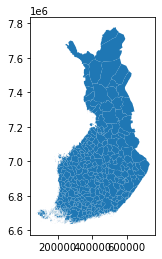

In [13]:
geodata.plot()

## Join Health district info to the municipality polygons

In [14]:
geodata = geodata.merge(data, left_on="kunta", right_on="code", how="left")

In [15]:
# Select useful columns
geodata = geodata[['id', 'code','name', 'healthCareDistrict', 'geometry']]

In [16]:
geodata.head()

,id,code,name,healthCareDistrict,geometry
0,kunta1000k.1,005,Alajärvi,Etelä-Pohjanmaa,"POLYGON ((366787.924 7001300.583, 364487.590 6..."
1,kunta1000k.2,009,Alavieska,Pohjois-Pohjanmaa,"POLYGON ((382543.364 7120022.976, 382899.505 7..."
2,kunta1000k.3,010,Alavus,Etelä-Pohjanmaa,"POLYGON ((343298.204 6961570.195, 343831.847 6..."
3,kunta1000k.4,016,Asikkala,Päijät-Häme,"POLYGON ((436139.680 6798279.085, 435714.468 6..."
4,kunta1000k.5,018,Askola,HUS,"POLYGON ((426631.036 6720528.076, 428821.749 6..."


In [17]:
# Municipalities in the Åland island did not have a matching health care district in the data
# Uncomment the following line to list these municipalities
#geodata[geodata.healthCareDistrict.notnull()==False].name

## Create polygons for health care districts 

In [18]:
# Dissolve (=combine) municipality polygon geometries for each health care district
districts = geodata.dissolve(by='healthCareDistrict')

In [19]:
districts.reset_index(inplace=True)

In [20]:
districts = districts[['healthCareDistrict', 'geometry']]

(141907.81934, 761050.55146, 6575077.820610001, 7833703.7515899995)

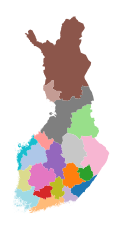

In [21]:
districts.plot(column='healthCareDistrict', scheme="equal_interval",cmap='tab20', k=20)
plt.axis('off')

In [22]:
# Write GeoJSON in original projection
districts.to_file("healthDistrictsEPSG3067.geojson", driver='GeoJSON', encoding = 'utf-8')

In [23]:
# Re-project to WGS84 and save again
wgs84 = CRS.from_epsg(4326)
districts.to_crs(wgs84).to_file("healthDistrictsEPSG4326.geojson", driver='GeoJSON', encoding = 'utf-8')

## Join covid-19 cases to districts

join confirmed cases to districts based on common key:

In [24]:
covid_and_regions = districts.merge(covid, on="healthCareDistrict", how="left")

In [25]:
covid_and_regions.columns.values

array(['healthCareDistrict', 'geometry', 'id', 'date',
       'infectionSourceCountry', 'infectionSource'], dtype=object)

### Confirmed cases per region

In [26]:
id_count = covid_and_regions.groupby(by='healthCareDistrict').id.count()

In [27]:
id_count.rename("confirmed_count", inplace=True).sort_values(ascending=False)

healthCareDistrict
HUS                  18
Pirkanmaa             5
Varsinais-Suomi       1
Pohjois-Savo          1
Pohjois-Pohjanmaa     1
Lappi                 1
Keski-Pohjanmaa       0
Etelä-Pohjanmaa       0
Etelä-Savo            0
Itä-Savo              0
Kainuu                0
Kanta-Häme            0
Kymenlaakso           0
Keski-Suomi           0
Vaasa                 0
Länsi-Pohja           0
Pohjois-Karjala       0
Päijät-Häme           0
Satakunta             0
Etelä-Karjala         0
Name: confirmed_count, dtype: int64

Join count of cases to district polygons

In [28]:
districts = districts.merge(id_count, left_on='healthCareDistrict', right_index=True)

In [29]:
# Set zero to no data for plotting
districts.replace({0:np.nan}, inplace=True)

(141907.81934, 761050.55146, 6575077.820610001, 7833703.7515899995)

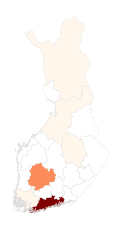

In [30]:
# Plot values on the map
districts.plot(column='confirmed_count', 
               cmap='OrRd', 
               edgecolor="lightgray", 
               linewidth=.2,
               scheme="Natural_Breaks", 
               k=3, 
               missing_kwds={'color': 'white'})

# Remove frame
plt.axis('off')

### Cases per source

In [31]:
source_count = covid_and_regions.groupby(by='infectionSourceCountry').id.count()

In [32]:
source_count.rename("cases_per_country", inplace=True)

infectionSourceCountry
CHN     1
FIN     8
ITA    18
Name: cases_per_country, dtype: int64

## Join sources to countries

In [33]:
# Geopandas comes with natural earth polygons
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [34]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [35]:
world = world.merge(source_count, left_on="iso_a3", right_index=True, how="left")

In [36]:
world[["name","cases_per_country"]].dropna()

,name,cases_per_country
139,China,1.0
141,Italy,18.0
151,Finland,8.0
